# Visualize neural dynamics

In [56]:
%reset
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats 

from sklearn.decomposition import PCA
from scipy.stats import zscore
from umap import UMAP


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Usefull funtions

In [57]:


def load_vestibular_v1_sources(filename="vestibular_V1_sources.h5"):
    data = {}
    with h5py.File(filename, "r") as f:
        # -----------------------------------------------------------------
        # Responses (dict of arrays)
        # -----------------------------------------------------------------
        data["responses"] = {}
        for cond in f["responses"]:
            data["responses"][cond] = f["responses"][cond][()]  # (neurons, time_in_trial, trials)

        # -----------------------------------------------------------------
        # Velocity (dict of arrays)
        # -----------------------------------------------------------------
        data["velocity"] = {}
        for cond in f["velocity"]:
            data["velocity"][cond] = f["velocity"][cond][()]  # (time_in_trial, trials)

        # -----------------------------------------------------------------
        # Metadata
        # -----------------------------------------------------------------
        data["metadata"] = {}

        # trial_direction and time
        data["metadata"]["trial_direction"] = f["metadata/trial_direction"][()]
        data["metadata"]["time"] = f["metadata/time"][()]

        # info table (rebuild as pandas DataFrame)
        info_dict = {}
        for col in f["metadata/info"]:
            vals = f["metadata/info"][col][()]
            # Decode byte strings if necessary
            if isinstance(vals[0], (bytes, np.bytes_)):
                vals = [v.decode() for v in vals]
            info_dict[col] = vals
        data["metadata"]["info"] = pd.DataFrame(info_dict)

    return data

# Helper for mean ± SEM
def mean_sem(data, mask):
    x = data[:, mask]
    mean = x.mean(axis=1)
    sem  = x.std(axis=1, ddof=1) / np.sqrt(x.shape[1])
    return mean, sem



# -----------------------------------------------------------------
# Example usage
# -----------------------------------------------------------------
dataset = load_vestibular_v1_sources("vestibular_V1_sources.h5")

print("Responses keys:", dataset["responses"].keys())
print("Velocity keys:", dataset["velocity"].keys())
print("Info DataFrame:")
print(dataset["metadata"]["info"].head())

print("Responses[control] shape:", dataset["responses"]["control"].shape)
print("Velocity[control] shape:", dataset["velocity"]["control"].shape)


Responses keys: dict_keys(['LED', 'MSC', 'MSC_LED', 'control'])
Velocity keys: dict_keys(['LED', 'MSC', 'MSC_LED', 'control'])
Info DataFrame:
  Experiment  depth  n_cells
0         V1  700.0     1829
1         V1  900.0     1829
2         V1  950.0     1829
3         V1  600.0     1829
4         V1  600.0     1829
Responses[control] shape: (2887, 100, 54)
Velocity[control] shape: (100, 54)


## Plot example V1 neuron in control conditions

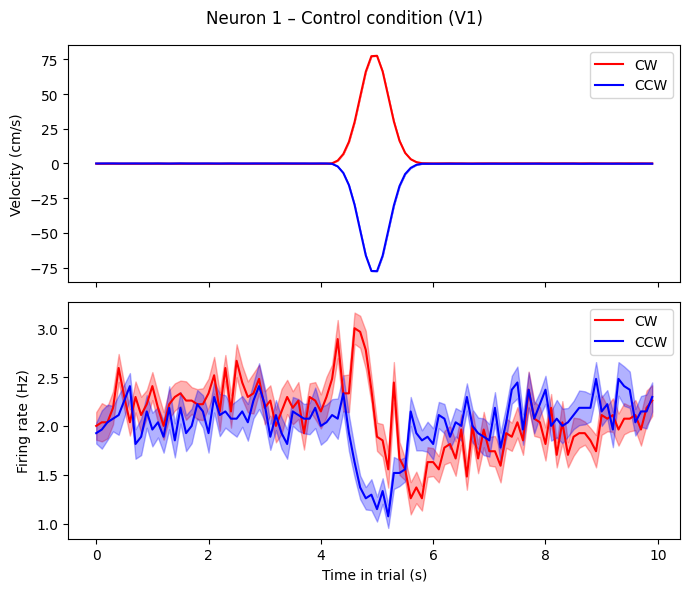

In [58]:

# Pick neuron index
neuron_idx = 1 

# Extract data
resp_control = dataset["responses"]["control"][neuron_idx, :, :]  # (time, trials)
vel_control  = dataset["velocity"]["control"]                     # (time, trials)
trial_dir    = dataset["metadata"]["trial_direction"]             # (trials,)

# Identify area from info table
exp_label = dataset["metadata"]["info"].loc[neuron_idx, "Experiment"]
area = "LP" if exp_label == "LP" else "V1"

# Time axis (100 ms bins)
T_trial = resp_control.shape[0]
time_axis = np.arange(T_trial) * 0.1  # seconds

# Trial masks
if trial_dir.dtype.kind in {"U", "S"}:  # string type
    cw_mask  = trial_dir == "CW"
    ccw_mask = trial_dir == "CCW"
else:  # numeric coding, assume CW=+1, CCW=-1
    cw_mask  = trial_dir > 0
    ccw_mask = trial_dir < 0


# Velocity averages
vel_cw_mean, vel_cw_sem   = mean_sem(vel_control, cw_mask)
vel_ccw_mean, vel_ccw_sem = mean_sem(vel_control, ccw_mask)

# Response averages
resp_cw_mean, resp_cw_sem   = mean_sem(resp_control, cw_mask)
resp_ccw_mean, resp_ccw_sem = mean_sem(resp_control, ccw_mask)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(7,6), sharex=True)

# Top: velocity
axs[0].plot(time_axis, vel_cw_mean, color="red", label="CW")
axs[0].fill_between(time_axis, vel_cw_mean-vel_cw_sem, vel_cw_mean+vel_cw_sem,
                    color="red", alpha=0.3)
axs[0].plot(time_axis, vel_ccw_mean, color="blue", label="CCW")
axs[0].fill_between(time_axis, vel_ccw_mean-vel_ccw_sem, vel_ccw_mean+vel_ccw_sem,
                    color="blue", alpha=0.3)
axs[0].set_ylabel("Velocity (cm/s)")
axs[0].legend()

# Bottom: firing rate
axs[1].plot(time_axis, resp_cw_mean, color="red", label="CW")
axs[1].fill_between(time_axis, resp_cw_mean-resp_cw_sem, resp_cw_mean+resp_cw_sem,
                    color="red", alpha=0.3)
axs[1].plot(time_axis, resp_ccw_mean, color="blue", label="CCW")
axs[1].fill_between(time_axis, resp_ccw_mean-resp_ccw_sem, resp_ccw_mean+resp_ccw_sem,
                    color="blue", alpha=0.3)
axs[1].set_xlabel("Time in trial (s)")
axs[1].set_ylabel("Firing rate (Hz)")
axs[1].legend()

# Title with area
plt.suptitle(f"Neuron {neuron_idx} – Control condition ({area})")

plt.tight_layout()
plt.show()


## plot example V1 neuron in MSC experiment

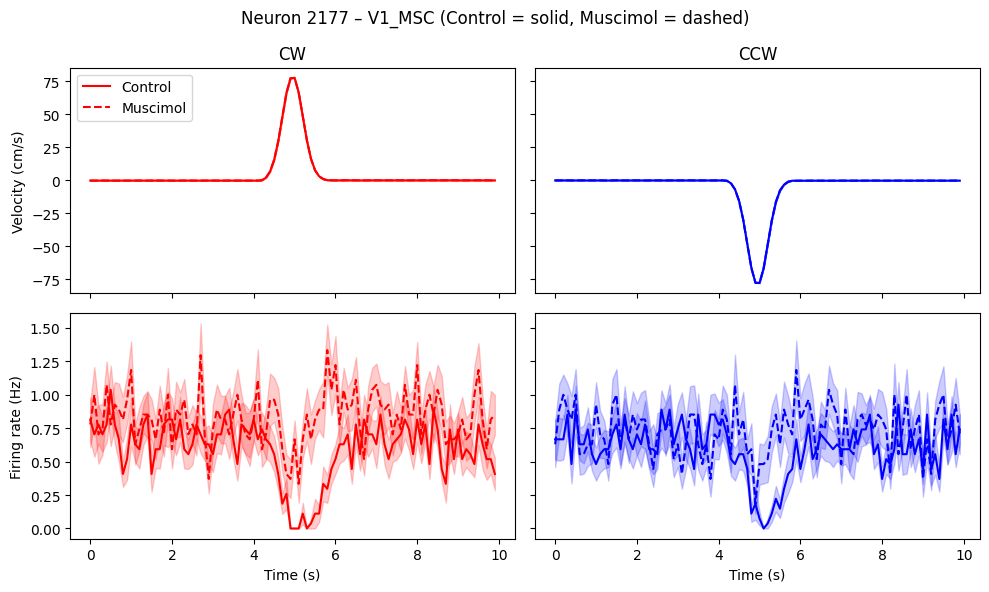

In [59]:
# --- find all neurons from V1_MSC experiment ---
info_df = dataset["metadata"]["info"]
v1_msc_neurons = np.where(info_df["Experiment"] == "V1_MSC")[0]


# --- choose a neuron index from this list ---
neuron_idx = v1_msc_neurons[10]  # <-- change this number to pick another

# --- extract arrays ---
resp_ctrl = dataset["responses"]["control"][neuron_idx, :, :]  # (time, trials)
resp_msc  = dataset["responses"]["MSC"][neuron_idx, :, :]
vel_ctrl  = dataset["velocity"]["control"]                     # (time, trials)
vel_msc   = dataset["velocity"]["MSC"]                         # (time, trials)
trial_dir = dataset["metadata"]["trial_direction"]

# trial direction mask (CW vs CCW)
if trial_dir.dtype.kind in {"U", "S", "O"}:
    if trial_dir.dtype.kind == "S":
        trial_dir = np.array([t.decode() for t in trial_dir])
    cw_mask  = (trial_dir == "CW")
    ccw_mask = (trial_dir == "CCW")
else:
    cw_mask  = trial_dir > 0
    ccw_mask = trial_dir < 0

# time axis: 100 ms bins
T = resp_ctrl.shape[0]
t = np.arange(T) * 0.1


# averages
vel_cw_ctrl, vel_cw_ctrl_sem   = mean_sem(vel_ctrl, cw_mask)
vel_ccw_ctrl, vel_ccw_ctrl_sem = mean_sem(vel_ctrl, ccw_mask)
vel_cw_msc,  vel_cw_msc_sem    = mean_sem(vel_msc, cw_mask)
vel_ccw_msc, vel_ccw_msc_sem   = mean_sem(vel_msc, ccw_mask)

resp_cw_ctrl, resp_cw_ctrl_sem   = mean_sem(resp_ctrl, cw_mask)
resp_ccw_ctrl, resp_ccw_ctrl_sem = mean_sem(resp_ctrl, ccw_mask)
resp_cw_msc,  resp_cw_msc_sem    = mean_sem(resp_msc, cw_mask)
resp_ccw_msc, resp_ccw_msc_sem   = mean_sem(resp_msc, ccw_mask)

# --- 2x2 plot ---
fig, axs = plt.subplots(2, 2, figsize=(10,6), sharex=True, sharey='row')

# top-left: velocity CW
axs[0,0].plot(t, vel_cw_ctrl, color="red", linestyle="-", label="Control")
axs[0,0].fill_between(t, vel_cw_ctrl-vel_cw_ctrl_sem, vel_cw_ctrl+vel_cw_ctrl_sem, color="red", alpha=0.2)
axs[0,0].plot(t, vel_cw_msc, color="red", linestyle="--", label="Muscimol")
axs[0,0].fill_between(t, vel_cw_msc-vel_cw_msc_sem, vel_cw_msc+vel_cw_msc_sem, color="red", alpha=0.2)
axs[0,0].set_ylabel("Velocity (cm/s)")
axs[0,0].set_title("CW")
axs[0,0].legend(loc="upper left")

# top-right: velocity CCW
axs[0,1].plot(t, vel_ccw_ctrl, color="blue", linestyle="-")
axs[0,1].fill_between(t, vel_ccw_ctrl-vel_ccw_ctrl_sem, vel_ccw_ctrl+vel_ccw_ctrl_sem, color="blue", alpha=0.2)
axs[0,1].plot(t, vel_ccw_msc, color="blue", linestyle="--")
axs[0,1].fill_between(t, vel_ccw_msc-vel_ccw_msc_sem, vel_ccw_msc+vel_ccw_msc_sem, color="blue", alpha=0.2)
axs[0,1].set_title("CCW")

# bottom-left: response CW
axs[1,0].plot(t, resp_cw_ctrl, color="red", linestyle="-")
axs[1,0].fill_between(t, resp_cw_ctrl-resp_cw_ctrl_sem, resp_cw_ctrl+resp_cw_ctrl_sem, color="red", alpha=0.2)
axs[1,0].plot(t, resp_cw_msc, color="red", linestyle="--")
axs[1,0].fill_between(t, resp_cw_msc-resp_cw_msc_sem, resp_cw_msc+resp_cw_msc_sem, color="red", alpha=0.2)
axs[1,0].set_ylabel("Firing rate (Hz)")
axs[1,0].set_xlabel("Time (s)")

# bottom-right: response CCW
axs[1,1].plot(t, resp_ccw_ctrl, color="blue", linestyle="-")
axs[1,1].fill_between(t, resp_ccw_ctrl-resp_ccw_ctrl_sem, resp_ccw_ctrl+resp_ccw_ctrl_sem, color="blue", alpha=0.2)
axs[1,1].plot(t, resp_ccw_msc, color="blue", linestyle="--")
axs[1,1].fill_between(t, resp_ccw_msc-resp_ccw_msc_sem, resp_ccw_msc+resp_ccw_msc_sem, color="blue", alpha=0.2)
axs[1,1].set_xlabel("Time (s)")

plt.suptitle(f"Neuron {neuron_idx} – V1_MSC (Control = solid, Muscimol = dashed)")
plt.tight_layout()
plt.show()

## UMAP


Dropping 8 neuron(s) with NaNs in train features.


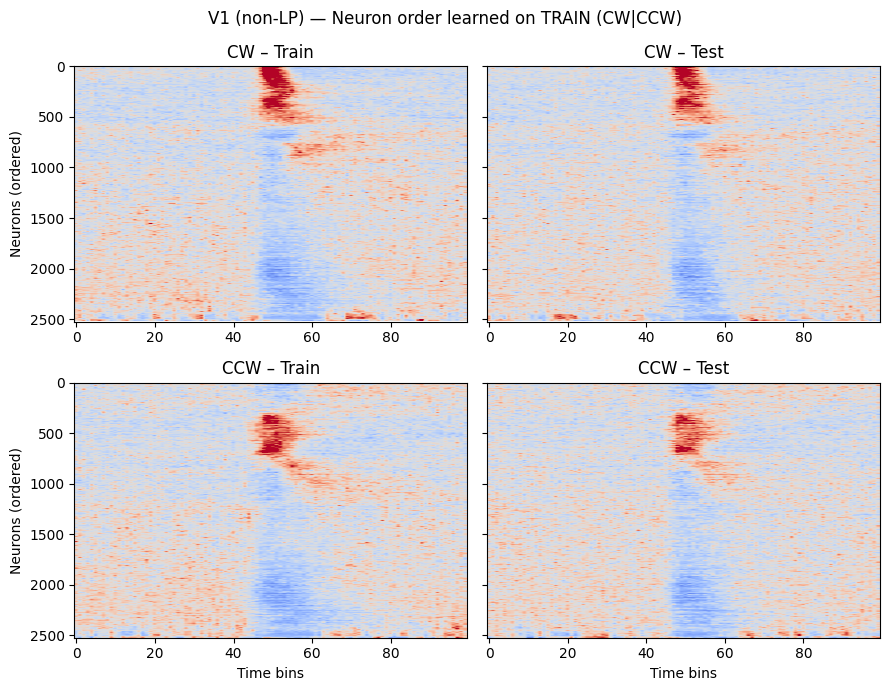

In [60]:
# ----------------------------
# Short names
# ----------------------------
DF = dataset["metadata"]["info"].copy()
R  = dataset["responses"]["control"]          # (neurons, time, trials)
td_raw = dataset["metadata"]["trial_direction"]

# ----------------------------
# 1) Keep only neurons in V1
# ----------------------------
mask_cells = (DF['Experiment'] != 'LP').values
R  = R[mask_cells, :, :]                     # (neurons_keep, time, trials)
DF = DF.loc[mask_cells].reset_index(drop=True)

# ----------------------------
# 2) Build CW / CCW boolean masks robustly
# ----------------------------
td = np.asarray(td_raw)

def get_cw_ccw_masks(td):
    # Strings/bytes
    if td.dtype.kind in {'U', 'S', 'O'}:
        td_str = []
        for t in td:
            if isinstance(t, (bytes, np.bytes_)):
                td_str.append(t.decode())
            else:
                td_str.append(str(t))
        td_up = np.char.upper(np.array(td_str, dtype=object))
        cw = (td_up == 'CW')
        ccw = (td_up == 'CCW')
        if cw.any() and ccw.any():
            return cw, ccw
    # Numeric encodings
    td_num = td.astype(float)
    if np.any(td_num > 0) and np.any(td_num < 0):
        return (td_num > 0), (td_num < 0)
    uniq = np.unique(td_num)
    if set(uniq) == {0.0, 1.0}:
        return (td_num == 1.0), (td_num == 0.0)
    if len(uniq) == 2:
        return (td_num == uniq.max()), (td_num == uniq.min())
    # Fallback: alternate trials
    idx = np.arange(len(td_num))
    return (idx % 2 == 0), (idx % 2 == 1)

cw_mask, ccw_mask = get_cw_ccw_masks(td)

# ----------------------------
# 3) Split trials into first/second halves per direction
# ----------------------------
def halves(mask_bool):
    idx = np.where(mask_bool)[0]
    n = len(idx)
    if n < 2:
        raise ValueError(f"Not enough trials in one direction to split (found {n}).")
    k = n // 2
    return idx[:k], idx[k:]

cw_1,  cw_2  = halves(cw_mask)
ccw_1, ccw_2 = halves(ccw_mask)

# ----------------------------
# 4) Trial-average 
#    Train = first halves; Test = second halves
# ----------------------------
# shapes: (neurons, time)
cw_train   = np.nanmean(R[:, :, cw_1],   axis=2)
cw_test    = np.nanmean(R[:, :, cw_2],   axis=2)
ccw_train  = np.nanmean(R[:, :, ccw_1],  axis=2)
ccw_test   = np.nanmean(R[:, :, ccw_2],  axis=2)

# ----------------------------
# 5) Build train/test feature matrices and z-score (per neuron)
#    Ordering learned on TRAIN concatenated (CW|CCW)
# ----------------------------
Train_concat = np.concatenate([cw_train, ccw_train], axis=1)   # (neurons, 2*time)
Test_concat  = np.concatenate([cw_test,  ccw_test],  axis=1)

Z_train_concat = zscore(Train_concat, axis=1, ddof=1)
Z_test_concat  = zscore(Test_concat,  axis=1, ddof=1)

# Drop neurons with any NaN in TRAIN features (to keep PCA/UMAP happy)
valid_neurons = np.isfinite(Z_train_concat).all(axis=1)
Z_train_concat = Z_train_concat[valid_neurons, :]
Z_test_concat  = Z_test_concat[valid_neurons, :]
DF_valid = DF.loc[valid_neurons].reset_index(drop=True)

# Also make per-direction z-scored matrices for plotting (keep same subset of neurons)
Z_cw_train  = zscore(cw_train[valid_neurons, :],  axis=1, ddof=1)
Z_cw_test   = zscore(cw_test[valid_neurons, :],   axis=1, ddof=1)
Z_ccw_train = zscore(ccw_train[valid_neurons, :], axis=1, ddof=1)
Z_ccw_test  = zscore(ccw_test[valid_neurons, :],  axis=1, ddof=1)

# Replace any lingering NaNs (e.g., zero-variance rows) with 0 for plotting
for M in (Z_cw_train, Z_cw_test, Z_ccw_train, Z_ccw_test):
    np.nan_to_num(M, copy=False)

# ----------------------------
# 6) PCA -> UMAP to get ordering on TRAIN (CW|CCW)
# ----------------------------
n_pca = min(50, Z_train_concat.shape[0], Z_train_concat.shape[1])
pca = PCA(n_components=n_pca, random_state=0)
X   = pca.fit_transform(Z_train_concat)

xinit = zscore(X[:, :1], axis=0)
embed = UMAP(n_components=1,
             init=xinit,
             n_neighbors=50,
             metric='correlation',
             transform_seed=42).fit_transform(X)
isort = np.argsort(embed.ravel())[::-1]

# ----------------------------
# 7) 2×2 rasterplots: rows = CW / CCW, cols = Train / Test
# ----------------------------
try:
    color_map
except NameError:
    color_map = 'coolwarm'

fig, axs = plt.subplots(2, 2, figsize=(9, 7), sharex=False, sharey=True)

# Row 1: CW
axs[0, 0].imshow(Z_cw_train[isort, :], vmax=2, vmin=-2, aspect='auto', cmap=color_map)
axs[0, 0].set_title("CW – Train")
axs[0, 0].set_ylabel("Neurons (ordered)")

axs[0, 1].imshow(Z_cw_test[isort, :], vmax=2, vmin=-2, aspect='auto', cmap=color_map)
axs[0, 1].set_title("CW – Test")

# Row 2: CCW
axs[1, 0].imshow(Z_ccw_train[isort, :], vmax=2, vmin=-2, aspect='auto', cmap=color_map)
axs[1, 0].set_title("CCW – Train")
axs[1, 0].set_xlabel("Time bins")
axs[1, 0].set_ylabel("Neurons (ordered)")

axs[1, 1].imshow(Z_ccw_test[isort, :], vmax=2, vmin=-2, aspect='auto', cmap=color_map)
axs[1, 1].set_title("CCW – Test")
axs[1, 1].set_xlabel("Time bins")

plt.suptitle("V1 (non-LP) — Neuron order learned on TRAIN (CW|CCW)")
plt.tight_layout()
plt.show()


## PCA spectrum and dynamics

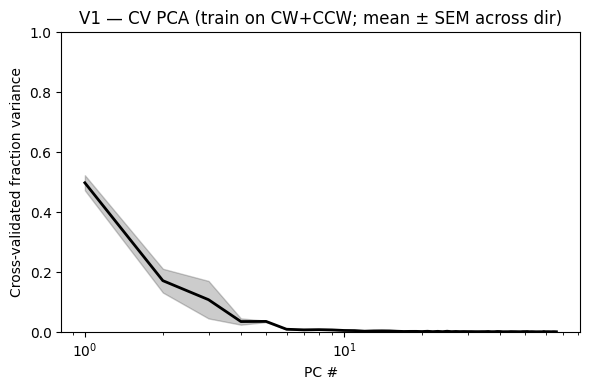

In [94]:

# --- helper stays the same ---
def block_mean_time(X, bin_coarse=10):
    n, T = X.shape
    T2 = (T // bin_coarse) * bin_coarse
    if T2 == 0:
        raise ValueError(f"time dimension {T} is smaller than bin_coarse={bin_coarse}")
    return X[:, :T2].reshape(n, T2 // bin_coarse, bin_coarse).mean(axis=2)

# --- train on CW+CCW combined; evaluate on each test set via test covariance ---
def cv_pca_fraction_combined(Xtr_cw, Xtr_ccw, Xte_cw, Xte_ccw, bin_coarse):
    # z-score per neuron across time
    Ztr_cw = stats.zscore(Xtr_cw, axis=1, ddof=1); np.nan_to_num(Ztr_cw, copy=False)
    Ztr_cc = stats.zscore(Xtr_ccw, axis=1, ddof=1); np.nan_to_num(Ztr_cc, copy=False)
    Zte_cw = stats.zscore(Xte_cw, axis=1, ddof=1); np.nan_to_num(Zte_cw, copy=False)
    Zte_cc = stats.zscore(Xte_ccw, axis=1, ddof=1); np.nan_to_num(Zte_cc, copy=False)

    # optional coarse binning (can set bin_coarse=1 to skip)
    Ztr_cw_c = block_mean_time(Ztr_cw, bin_coarse)
    Ztr_cc_c = block_mean_time(Ztr_cc, bin_coarse)
    Zte_cw_c = block_mean_time(Zte_cw, bin_coarse)
    Zte_cc_c = block_mean_time(Zte_cc, bin_coarse)

    # ---- Train PCs on CW+CCW concatenated along time ----
    Xtr_all = np.concatenate([Ztr_cw_c, Ztr_cc_c], axis=1)   # (n, T_all)
    T_all   = Xtr_all.shape[1]
    U, S, Vt = np.linalg.svd(Xtr_all / np.sqrt(T_all), full_matrices=False)  # PCs (columns) in U
    lam = S**2
    frac_train = lam / lam.sum() if lam.sum() > 0 else lam

    # ---- Cross-validated fraction on a test direction using test covariance ----
    # diag(U^T C_test U), where C_test = (X_test X_test^T)/T_test
    def frac_on_test(Xte_c):
        T_dir = Xte_c.shape[1]
        coeff = U.T @ Xte_c                 # (r, T_dir)
        diag  = np.sum(coeff**2, axis=1) / T_dir
        denom = diag.sum()
        return diag / denom if denom > 0 else diag

    frac_test_cw  = frac_on_test(Zte_cw_c)
    frac_test_ccw = frac_on_test(Zte_cc_c)

    return frac_train, frac_test_cw, frac_test_ccw

# ---- V1-only CV-PCA plots (TRAIN on CW+CCW combined) ----
bin_coarse = 3  

frac_train_comb, frac_test_cw, frac_test_ccw = cv_pca_fraction_combined(
    cw_train, ccw_train, cw_test, ccw_test, bin_coarse=bin_coarse
)

# Average CW & CCW (align lengths if needed)
L = min(len(frac_test_cw), len(frac_test_ccw))
F = np.vstack([frac_test_cw[:L], frac_test_ccw[:L]])  # (2, n_comp)

# Mean ± SEM across directions
f_mean = F.mean(axis=0)
f_sem  = F.std(axis=0, ddof=1) / np.sqrt(F.shape[0])



# ---- Plot: CV fraction variance ----
x = np.arange(1, L+1)
plt.figure(figsize=(6,4))
plt.semilogx(x, f_mean, color='k', lw=2, label='V1 (CV, train on CW+CCW)')
plt.fill_between(x, f_mean - f_sem, f_mean + f_sem, color='k', alpha=0.2)
plt.xlabel("PC #")
plt.ylabel("Cross-validated fraction variance")
plt.title("V1 — CV PCA (train on CW+CCW; mean ± SEM across dir)")
plt.ylim([0,1])
plt.tight_layout()
plt.show()



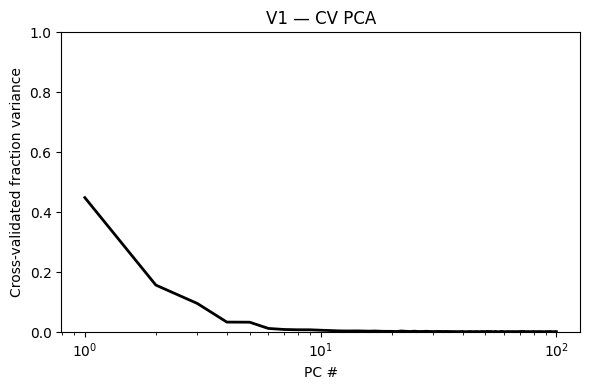

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- helper: non-overlapping block mean along time ---
def block_mean_time(X, bin_coarse=10):
    n, T = X.shape
    T2 = (T // bin_coarse) * bin_coarse
    if T2 == 0:
        raise ValueError(f"time dimension {T} is smaller than bin_coarse={bin_coarse}")
    return X[:, :T2].reshape(n, T2 // bin_coarse, bin_coarse).mean(axis=2)

# --- CV-PCA where PCs are trained on combined train (CW+CCW),
#     and test fraction is computed on combined test (CW+CCW).
#     We also return CW/CCW test fractions so you can show SEM if you want. ---
def cv_pca_fraction_combined(cw_tr, ccw_tr, cw_te, ccw_te, bin_coarse=1):
    # z-score per neuron across time
    Ztr_cw = stats.zscore(cw_tr,  axis=1, ddof=1); np.nan_to_num(Ztr_cw, copy=False)
    Ztr_cc = stats.zscore(ccw_tr, axis=1, ddof=1); np.nan_to_num(Ztr_cc, copy=False)
    Zte_cw = stats.zscore(cw_te,  axis=1, ddof=1); np.nan_to_num(Zte_cw, copy=False)
    Zte_cc = stats.zscore(ccw_te, axis=1, ddof=1); np.nan_to_num(Zte_cc, copy=False)

    # optional coarse binning (set bin_coarse=1 to effectively skip)
    Ztr_cw_c = block_mean_time(Ztr_cw, bin_coarse)
    Ztr_cc_c = block_mean_time(Ztr_cc, bin_coarse)
    Zte_cw_c = block_mean_time(Zte_cw, bin_coarse)
    Zte_cc_c = block_mean_time(Zte_cc, bin_coarse)

    # combine along time
    Xtr_all = np.concatenate([Ztr_cw_c, Ztr_cc_c], axis=1)  # (n, T_train_all)
    Xte_all = np.concatenate([Zte_cw_c, Zte_cc_c], axis=1)  # (n, T_test_all)

    # train PCs on combined train via SVD (cov = XX^T / T)
    T_all = Xtr_all.shape[1]
    U, S, _ = np.linalg.svd(Xtr_all / np.sqrt(T_all), full_matrices=False)  # U: neurons×r
    lam = S**2
    frac_train = lam / lam.sum() if lam.sum() > 0 else lam

    # helper: fraction on a given test matrix using test covariance
    def frac_on_test(X):
        Tdir = X.shape[1]
        coeff = U.T @ X               # (r, Tdir)
        diag  = np.sum(coeff**2, axis=1) / Tdir
        denom = diag.sum()
        return diag / denom if denom > 0 else diag

    # combined test (this is the one you asked for)
    frac_test_all = frac_on_test(Xte_all)

    # optional: per-direction for SEM band
    frac_test_cw  = frac_on_test(Zte_cw_c)
    frac_test_ccw = frac_on_test(Zte_cc_c)

    return frac_train, frac_test_all

# ================== RUN (train+test on combined) ==================
bin_coarse = 2

frac_train, frac_test_all= cv_pca_fraction_combined(
    cw_train, ccw_train, cw_test, ccw_test, bin_coarse=bin_coarse
)

# Prepare plot data: mean = combined test; SEM from CW/CCW (optional)
L = min(len(frac_test_all), len(frac_test_cw), len(frac_test_ccw))
f_mean = frac_test_all[:L]
F_dirs = np.vstack([frac_test_cw[:L], frac_test_ccw[:L]])  # 2 × L

# ---- Plot: CV fraction variance (combined test), log PC axis ----
x = np.arange(1, L+1)
plt.figure(figsize=(6,4))
plt.semilogx(x, f_mean, color='k', lw=2)
plt.xlabel("PC #")
plt.ylabel("Cross-validated fraction variance")
plt.title("V1 — CV PCA")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [96]:
# ---- Parameters ----
n_PCs = 3
bin_coarse = 1               # 100 ms bins
baseline_bins = 20           # baseline over first 20 bins (2 s at 100 ms)
colors = dict(CW="red", CCW="blue")

# ---- Build z-scored, (optionally) coarse-binned matrices (neurons x time) ----
# CW
Xtr_cw = stats.zscore(cw_train, axis=1, ddof=1); np.nan_to_num(Xtr_cw, copy=False)
Xte_cw = stats.zscore(cw_test,  axis=1, ddof=1); np.nan_to_num(Xte_cw, copy=False)
Xtr_cw_c = block_mean_time(Xtr_cw, bin_coarse=bin_coarse)
Xte_cw_c = block_mean_time(Xte_cw, bin_coarse=bin_coarse)

# CCW
Xtr_ccw = stats.zscore(ccw_train, axis=1, ddof=1); np.nan_to_num(Xtr_ccw, copy=False)
Xte_ccw = stats.zscore(ccw_test,  axis=1, ddof=1); np.nan_to_num(Xte_ccw, copy=False)
Xtr_ccw_c = block_mean_time(Xtr_ccw, bin_coarse=bin_coarse)
Xte_ccw_c = block_mean_time(Xte_ccw, bin_coarse=bin_coarse)

# ---- Combine CW+CCW along time for TRAIN and TEST ----
Tcw  = Xtr_cw_c.shape[1]
Tccw = Xtr_ccw_c.shape[1]

Xtr_all = np.concatenate([Xtr_cw_c, Xtr_ccw_c], axis=1)  # (neurons, Tcw+Tccw)
Xte_all = np.concatenate([Xte_cw_c, Xte_ccw_c], axis=1)  # (neurons, Tcw+Tccw)

# ---- Train covariance & eigenvectors on combined TRAIN ----
T_all = Xtr_all.shape[1]
M_train = (Xtr_all @ Xtr_all.T) / T_all                  # (neurons x neurons), symmetric
w, V = np.linalg.eigh(M_train)                           # ascending eigenvalues
order = np.argsort(w)[::-1]                              # descending
V = V[:, order]                                          # PCs as columns
r = min(n_PCs, V.shape[1])                               # number of PCs to show

# ---- Project combined TRAIN/TEST onto train PCs, then split back to CW/CCW ----
PC_train_all = (V[:, :r].T @ Xtr_all)                    # (r, Tcw+Tccw)
PC_test_all  = (V[:, :r].T @ Xte_all)

PC_cw_train  = PC_train_all[:, :Tcw]
PC_ccw_train = PC_train_all[:, Tcw:]
PC_cw_test   = PC_test_all[:, :Tcw]
PC_ccw_test  = PC_test_all[:, Tcw:]

# ---- Baseline subtraction ONLY (no amplitude normalization) ----
def baseline_only(Y, b=baseline_bins):
    Y = Y.copy()
    base = np.mean(Y[:, :max(1, b)], axis=1, keepdims=True)
    return Y - base

PC_cw_train  = baseline_only(PC_cw_train)
PC_cw_test   = baseline_only(PC_cw_test)
PC_ccw_train = baseline_only(PC_ccw_train)
PC_ccw_test  = baseline_only(PC_ccw_test)

# ---- Time axis in seconds ----
dt_coarse = 0.1 * bin_coarse
t = np.arange(Tcw) * dt_coarse  # (not needed for 3D, but handy if you also do 2D plots)

# ===================== Plotly 3D (TEST ONLY) =====================
# %pip install plotly  # if not installed
import plotly.graph_objects as go
import numpy as np

# Use the first 3 PCs from test projections
if r < 3:
    raise ValueError("Need at least 3 PCs; increase n_PCs.")

PCw = PC_cw_test[:3, :]   # shape (3, Tcw)
PCb = PC_ccw_test[:3, :]  # shape (3, Tccw)

fig = go.Figure()

# Trajectories
fig.add_trace(go.Scatter3d(
    x=PCw[0], y=PCw[1], z=PCw[2],
    mode='lines',
    line=dict(width=4, color='red'),
    name='CW (test)'
))
fig.add_trace(go.Scatter3d(
    x=PCb[0], y=PCb[1], z=PCb[2],
    mode='lines',
    line=dict(width=4, color='blue'),
    name='CCW (test)'
))


# Equal-ish aspect + labels
all_pts = np.hstack([PCw, PCb])
mins, maxs = all_pts.min(axis=1), all_pts.max(axis=1)
centers = (mins + maxs) / 2
half_range = np.max(maxs - mins) / 2

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3',
        xaxis=dict(range=[centers[0]-half_range, centers[0]+half_range]),
        yaxis=dict(range=[centers[1]-half_range, centers[1]+half_range]),
        zaxis=dict(range=[centers[2]-half_range, centers[2]+half_range]),
        aspectmode='cube'
    ),
    title='Test trajectories in PC space (PCs trained on CW+CCW)',
    margin=dict(l=0, r=150, t=40, b=0),
    legend=dict(x=1.02, y=0.5, xanchor='left', yanchor='middle')
)

fig.show()
